In [1]:
folder=''
zero_frac = 0.25
m_frac = 0.6
p_frac = 0.6
correction = 0.2
top_crop, bottom_crop, left_crop, right_crop = 60, 25, 0, 0
EPOCHS = 3

## Build Log

In [2]:
import pandas as pd
%matplotlib inline

In [3]:
driving_log = pd.read_csv('data22/driving_log.csv', header=None, names=['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed'], usecols=['center', 'left', 'right', 'steering']) 
#driving_log.head()

In [4]:
driving_log_back = pd.read_csv('data2back/driving_log.csv', header=None, names=['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed'], usecols=['center', 'left', 'right', 'steering']) 
#driving_log_back.head()

In [5]:
driving_log_dark = pd.read_csv('data2_dark/driving_log.csv', header=None, names=['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed'], usecols=['center', 'left', 'right', 'steering']) 
#driving_log_dark.head()

In [6]:
driving_log['steering'].describe()

count    22040.000000
mean        -0.008585
std          0.494100
min         -1.000000
25%         -0.103465
50%          0.000000
75%          0.096972
max          1.000000
Name: steering, dtype: float64

In [7]:
driving_log_back['steering'].describe()

count    17556.000000
mean         0.011378
std          0.510091
min         -1.000000
25%         -0.190584
50%          0.000000
75%          0.194020
max          1.000000
Name: steering, dtype: float64

In [8]:
driving_log_dark['steering'].describe()

count    4854.000000
mean        0.001325
std         0.476398
min        -1.000000
25%        -0.100000
50%         0.000000
75%         0.108030
max         1.000000
Name: steering, dtype: float64

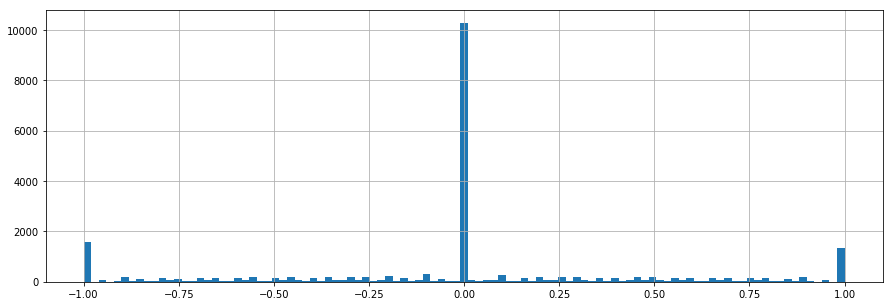

In [9]:
_ = driving_log['steering'].hist(bins=101, figsize=(15,5))

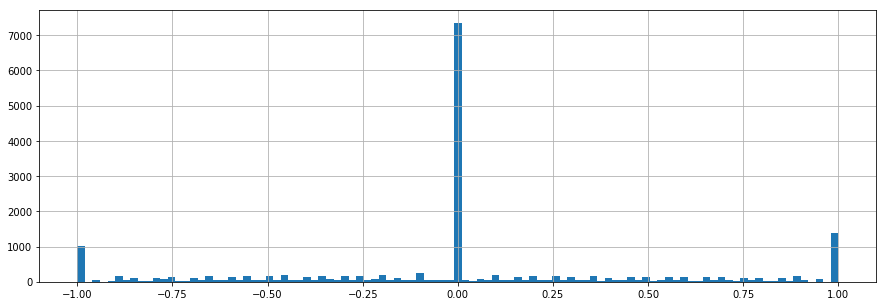

In [10]:
_ = driving_log_back['steering'].hist(bins=101, figsize=(15,5))

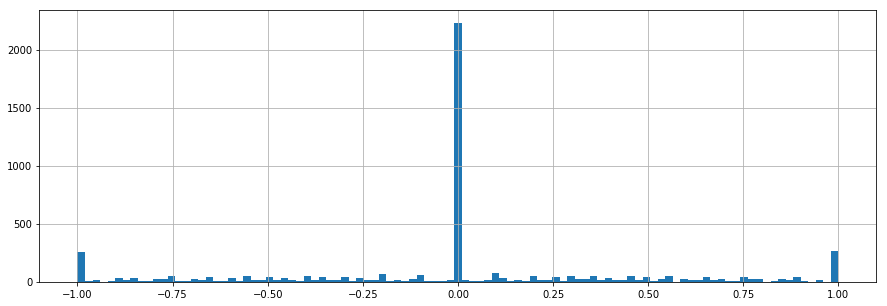

In [11]:
_ = driving_log_dark['steering'].hist(bins=101, figsize=(15,5))

In [12]:
driving_log = driving_log.append(driving_log_back).append(driving_log_dark)
driving_log = driving_log.sample(frac=1).reset_index(drop=True)

In [13]:
driving_log['steering'].describe()

count    44450.000000
mean         0.000382
std          0.498676
min         -1.000000
25%         -0.140130
50%          0.000000
75%          0.114975
max          1.000000
Name: steering, dtype: float64

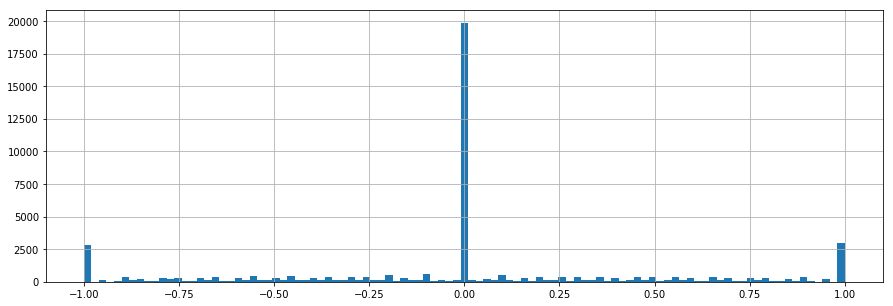

In [14]:
_ = driving_log['steering'].hist(bins=101, figsize=(15,5))

In [15]:
def undersample(log, value, frac):
    log_nonvalue = log[log['steering']!=value]
    log_value = log[log['steering']==value].sample(frac=frac)
    log = log_value.append(log_nonvalue)
    log = log.reset_index(drop=True)
    return log

In [16]:
driving_log = undersample(driving_log, 0, zero_frac)
driving_log = undersample(driving_log, -1, m_frac)
driving_log = undersample(driving_log, 1, p_frac)

In [17]:
driving_log['steering'].describe()

count    27357.000000
mean        -0.001573
std          0.565088
min         -1.000000
25%         -0.400000
50%          0.000000
75%          0.400000
max          1.000000
Name: steering, dtype: float64

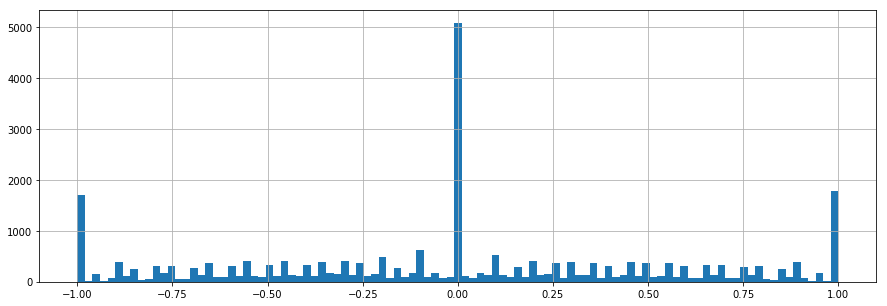

In [18]:
_ = driving_log['steering'].hist(bins=101, figsize=(15,5))

In [19]:
def augment_left_right(driving_log, correction):
    log = pd.DataFrame({'image':driving_log['center']
                                .append(driving_log['left'])
                                .append(driving_log['right']),
                        'steering':driving_log['steering']
                                .append(driving_log['steering'] + correction)
                                .append(driving_log['steering'] - correction)})

    #log = log[(log['steering']>=-1)&(log['steering']<=1)]
    return log

In [20]:
log = augment_left_right(driving_log, correction)

In [21]:
log['steering'].describe()

count    82071.000000
mean        -0.001573
std          0.588204
min         -1.200000
25%         -0.407180
50%          0.000000
75%          0.400000
max          1.200000
Name: steering, dtype: float64

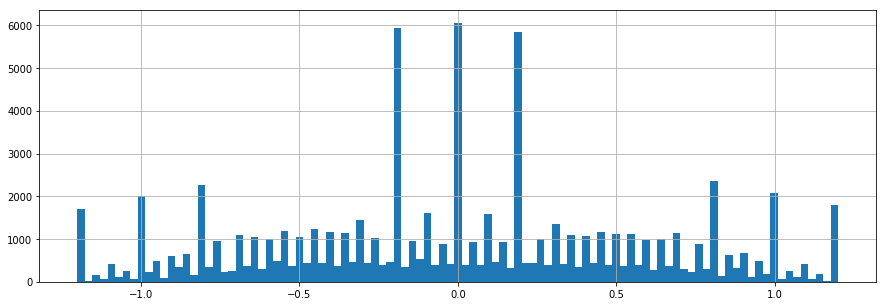

In [22]:
_ = log['steering'].hist(bins=101, figsize=(15,5))

In [23]:
log = log.sample(frac=1).reset_index(drop=True)  #shuffle log DataFrame

## Build Training and Validation Data

In [24]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D

from sklearn.model_selection import train_test_split
import sklearn

%matplotlib inline

Using TensorFlow backend.


In [25]:
log.head()

,image,steering
0,C:\Users\ETASMAK\Documents\CarND-Behavioral-Cl...,-0.344297
1,C:\Users\ETASMAK\Documents\CarND-Behavioral-Cl...,0.217315
2,C:\Users\ETASMAK\Documents\CarND-Behavioral-Cl...,-0.600000
3,C:\Users\ETASMAK\Documents\CarND-Behavioral-Cl...,-0.465107
4,C:\Users\ETASMAK\Documents\CarND-Behavioral-Cl...,-1.104606


In [26]:
train_log, validation_log = train_test_split(log, test_size=0.2)

train_log = train_log.reset_index(drop=True)
validation_log = validation_log.reset_index(drop=True)

In [27]:
def preprocess(image):
    #image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)[:,:,1]
    #image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = image[:,:,2]

    image = image[:,:,None]
    
    return image

In [28]:
def get_data(log):    
    images = []
    steerings = []
    
    for _, row in log.iterrows():
        filename = folder+row['image'].strip()
        image = preprocess(mpimg.imread(filename))
        image_flip = cv2.flip(image, 1)[:,:,None]
        steering = row['steering']

        images.extend([image, image_flip])
        steerings.extend([steering, -steering])

    X, y = np.array(images), np.array(steerings)
    X, y = sklearn.utils.shuffle(X, y)
    
    return X, y

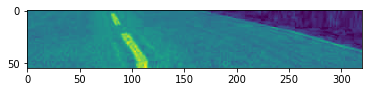

In [29]:
#filename = "C:\\Users\ETASMAK\Documents\CarND-Behavioral-Cloning-P3\data22\IMG\center_2017_03_18_12_41_42_030.jpg"
filename = "C:\\Users\ETASMAK\Documents\CarND-Behavioral-Cloning-P3\data22\IMG\center_2017_03_18_12_41_24_828.jpg"

image = mpimg.imread(filename)
#image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)[:,:,1]
image = image[top_crop+20:-bottom_crop,:,2]
plt.imshow(image[:,:,None].squeeze())

In [30]:
log.shape, train_log.shape, validation_log.shape

((82071, 2), (65656, 2), (16415, 2))

In [31]:
def generator(sample_log, batch_size=32):
    n_rows = len(sample_log)
    while 1: # Loop forever so the generator never terminates
        sample_log = sample_log.sample(frac=1).reset_index(drop=True)  #shuffle sample_log DataFrame
        
        for offset in range(0, n_rows, batch_size):
            batch_log = sample_log[offset : offset + batch_size]

            X, y = get_data(batch_log)
            
            yield X, y 

In [32]:
train_generator = generator(train_log, batch_size=128)
validation_generator = generator(validation_log, batch_size=128)

## Compile and train the model

In [33]:
model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160,320,1)))
model.add(Cropping2D(cropping=((top_crop, bottom_crop), (left_crop, right_crop)), input_shape=(160,320,1)))

model.add(Convolution2D(24,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(36,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(48,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(64,3,3, activation='relu'))
model.add(Convolution2D(64,3,3, activation='relu'))

model.add(Flatten())

model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))

model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
#history_object = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=2) 

history_object = model.fit_generator(train_generator,
                                     samples_per_epoch = len(train_log),
                                     validation_data = validation_generator, 
                                     nb_val_samples=len(validation_log),
                                     nb_epoch=EPOCHS,
                                     verbose=1)

Epoch 1/3
65536/65656 [============================>.] - ETA: 1s - loss: 0.1513   

C:\Users\ETASMAK\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\keras\engine\training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


65792/65656 [==============================] - 1064s - loss: 0.1513 - val_loss: 0.1222
Epoch 2/3
65776/65656 [==============================] - 1061s - loss: 0.1210 - val_loss: 0.1228

In [34]:
model.save('model.h5')

dict_keys(['loss', 'val_loss'])


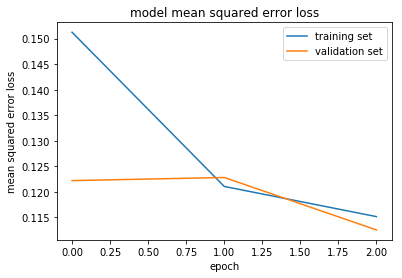

In [35]:
### print the keys contained in the history object
print(history_object.history.keys())
### plot the training and validation loss for each epoch

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')